## Se importan las librerias necesarias

In [1]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA
#para obtener el contenido de directorios y el working directory segun el path pasado opr parametro
from os import listdir, getcwd 
from os.path import isfile, join, basename #se usa para trabajar con archivos y rutas de archivo
from pmdarima import auto_arima #para trabajar con ARIMA
from tqdm import tqdm #progress bar para python CLI
from zipfile import ZipFile #para trabajar con ZIP
from typing import Awaitable #para trabajar con concurrencia
import asyncio#para trabajar con concurrencia
#import skillsnetwork
import numpy as np
import pandas as pd
import glob
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
def warn(*args, **kwargs):
    pass # Suppress warnings generated by your code
warnings.warn = warn
warnings.filterwarnings('ignore')

## *Helper Function*

_Se definen alguas funciones para uso interno y mejor legilibilidad del notebook_

In [2]:
def read_date_series_files(files, strat_time, end_time, join_type, col_read=None):
    folder = glob.glob(files)  # get files name
    dfs = pd.DataFrame(pd.date_range(start=strat_time, end=end_time, freq="d"), columns=["Date"])

    if join_type == "left":  # combine different columns from different files
        for f in folder:
            df = pd.read_csv(f, sep=",", header=0, usecols=col_read)
            df["Date"] = pd.to_datetime(df["Date"])
            dfs = dfs.merge(df, how=join_type, left_on="Date", right_on="Date")
            dfs.set_axis([*dfs.columns[:-1], basename(f).replace(".csv", "")], axis=1, inplace=True)
    elif join_type == "normal":  # combine same columns from different files
        df = [pd.read_csv(f, sep=",", header=0, usecols=col_read) for f in folder]
        dfs = pd.concat(df, ignore_index=True)
        dfs["Date"] = pd.to_datetime(dfs["Date"])

    dfs.set_index("Date", inplace=True)  # make the date become the index
    dfs = dfs.sort_index()
    return dfs


def find_first_date(df, display=False):
    global start_date, end_date
    i = df.isnull().sum().max()
    start_date = df.index[i]
    end_date = df.index[-1]
    if display:
        print("The first date in this time series is: ", start_date, "\n The last date in this time series is: ", end_date)


def clean_data(tv, pv):
    df1, df2 = tv.copy(), pv.copy()
    
    find_first_date(tv, True)
    df1 = df1[start_date:]

    df2 = df2[start_date:]
    df2.drop(["4 Mo"], axis=1, inplace=True)
    # fill missing datetime with previous day's values
    df2 = df2.reindex(pd.date_range(start_date, end_date)).reset_index().rename(columns={"index": "Date"})
    df2 = df2.groupby(df2["Date"].dt.time).ffill()
    df2.set_index("Date", inplace=True)
    return df1, df2


def prepare_data(dataset):
    df = dataset.copy()
    
    # normalized the data with min-max scaling
    df_nor = pd.DataFrame(MinMaxScaler().fit_transform(df)).assign(label=df.index)
    df_nor.columns = df.columns.to_list() + ["Date"]
    df_nor.set_index("Date", inplace=True)
    
    # we will remove the weak corellation (% between -0.2 to 0.2)
    cor = df_nor.corr(method="pearson")
    df_nor.drop(df_nor.columns[(cor.Index >= -0.2) & (cor.Index <= 0.2)], axis=1, inplace=True)
    return df_nor


def time_series_split(df, train_percent):
    train_size = int(len(df) * train_percent)
    predictor_train, target_train = pd.DataFrame(df.iloc[:train_size, :-1]), pd.DataFrame(df.iloc[:train_size, -1])
    predictor_test, target_test = pd.DataFrame(df.iloc[train_size:, :-1]), pd.DataFrame(df.iloc[train_size:, -1])
    return predictor_train, predictor_test, target_train, target_test


def decompose(df, period):
    decomposition = seasonal_decompose(df, model="additive", period=period)

    fig, axs = plt.subplots(4, 1, figsize=(18, 18))
    # original time series
    axs[0].plot(decomposition.observed)
    axs[0].set_title("Original Series", size=15)
    axs[0].xaxis.set_major_locator(plt.MaxNLocator(7))
    # trend
    axs[1].plot(decomposition.trend)
    axs[1].set_title("Trend", size=15)
    axs[1].xaxis.set_major_locator(plt.MaxNLocator(7))
    # seasonal
    axs[2].plot(decomposition.seasonal)
    axs[2].set_title("Seasonal", size=15)
    axs[2].xaxis.set_major_locator(plt.MaxNLocator(7))
    # residual
    axs[3].plot(decomposition.resid)
    axs[3].set_title("Residual", size=15)
    axs[3].xaxis.set_major_locator(plt.MaxNLocator(7))
    plt.show()


def stationary(df):
    ori_df = df  # original time series
    fir_df = df.diff().dropna()  # first difference time series
    sec_df = df.diff().diff().dropna()  # second difference time series
    stationary_test = None

    fig, axs = plt.subplots(3, 3, figsize=(21, 9))
    for i in range(3):
        if i == 0:
            print("Original Time Series")
            stationary_test = adfuller(ori_df)
            axs[i, 0].plot(ori_df)
            axs[i, 0].set_title("Original Time Series")
            axs[i, 0].label_outer()
            plot_acf(ori_df, ax=axs[i, 1])
            plot_pacf(ori_df, ax=axs[i, 2])
        elif i == 1:
            print("First Order Differencing")
            stationary_test = adfuller(fir_df)
            axs[i, 0].plot(fir_df)
            axs[i, 0].set_title("First Order Differencing")
            axs[i, 0].label_outer()
            plot_acf(fir_df, ax=axs[i, 1])
            plot_pacf(fir_df, ax=axs[i, 2])
        elif i == 2:
            print("Second Order Differencing")
            stationary_test = adfuller(sec_df)
            axs[i, 0].plot(sec_df)
            axs[i, 0].set_title("Second Order Differencing")
            axs[i, 0].label_outer()
            plot_acf(sec_df, ax=axs[i, 1])
            plot_pacf(sec_df, ax=axs[i, 2])

        print("ADF Statistic: %f" %stationary_test[0])
        print("p-value: %f\n" %stationary_test[1])

    # hide x and tick labels
    for ax in axs.flat:
        ax.label_outer()
    plt.show()


# create empty folder
#! mkdir my_crypto

## *Se cargan los datasets*

In [3]:
path = str(getcwd() + "/cryptocurrency/coins/*.csv")
cryptos = read_date_series_files(path, "2010-08-01", "2022-11-15", "left", ["Date", "Close"])

cryptos.tail(3)

,bnb,btc,doge,eth,ftx,usdc,usdt,xrp
Date,,,,,,,,
2022-11-13,279.372157,16349.997597,0.084762,1223.796978,1.491613,1.00010,0.998967,0.340153
2022-11-14,278.798441,16630.637464,0.085818,1242.592693,1.493649,1.00000,0.999167,0.374665
2022-11-15,277.250100,16894.926500,0.086965,1252.796100,1.841371,0.99995,0.998983,0.388356


In [4]:
path = str(getcwd() + "/cryptocurrency/interest_rate/*.csv")
rates = read_date_series_files(path, "2018-01-01", "2022-11-15", "normal")

rates.tail(3)

,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,2 Yr,3 Yr,5 Yr,7 Yr,10 Yr,20 Yr,30 Yr,4 Mo
Date,,,,,,,,,,,,,
2022-11-10,3.71,4.00,4.28,4.52,4.59,4.34,4.17,3.95,3.89,3.82,4.24,4.03,4.36
2022-11-14,3.72,4.05,4.34,4.55,4.63,4.40,4.24,4.00,3.95,3.88,4.28,4.07,4.38
2022-11-15,3.77,4.10,4.31,4.54,4.60,4.37,4.17,3.93,3.88,3.80,4.20,3.98,4.40


In [5]:
path = str(getcwd() + "/cryptocurrency/economic_index/*.csv")
economic_index = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Rate"])

economic_index.tail(3)

,consumer-price-index,personal-saving-rate
Date,,
2022-11-13,NaN,NaN
2022-11-14,NaN,NaN
2022-11-15,NaN,NaN


In [6]:
path = str(getcwd() + "/cryptocurrency/stock_index/*.csv")
stock_index = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Price"])

stock_index.tail(3)

,nasdaq,s&p500
Date,,
2022-11-13,NaN,NaN
2022-11-14,11196.22,3957.25
2022-11-15,11358.41,3991.73


In [7]:
path = str(getcwd() + "/cryptocurrency/metals/*.csv")
metals = read_date_series_files(path, "2018-01-01", "2022-11-15", "left", ["Date", "Price"])

metals.tail(3)

,gold,silver
Date,,
2022-11-13,NaN,NaN
2022-11-14,1771.80,21.97
2022-11-15,1778.25,21.54


In [8]:
find_first_date(cryptos, True)
redictor_variables = pd.DataFrame(pd.date_range(start=start_date, end=end_date, freq="d"), columns=["Date"])
redictor_variables = pd.concat([economic_index, stock_index, metals, rates], join="outer", axis=1)

The first date in this time series is:  2019-08-01 00:00:00 
 The last date in this time series is:  2022-11-15 00:00:00


In [9]:
coins, factors = clean_data(cryptos, redictor_variables)
coins.head()

The first date in this time series is:  2019-08-01 00:00:00 
 The last date in this time series is:  2022-11-15 00:00:00


,bnb,btc,doge,eth,ftx,usdc,usdt,xrp
Date,,,,,,,,
2019-08-01,28.825245,10365.984725,0.003021,216.682904,1.764991,0.998697,1.000150,0.316111
2019-08-02,27.897553,10523.946375,0.002941,217.707303,1.788899,0.998358,1.000052,0.312148
2019-08-03,27.767187,10806.817074,0.003021,221.743629,1.807864,0.998643,0.999433,0.316359
2019-08-04,27.392874,10948.187620,0.002928,221.665372,1.795479,0.995438,1.001469,0.319044
2019-08-05,27.852035,11782.652144,0.003139,232.392510,1.749577,0.998896,0.997122,0.321105


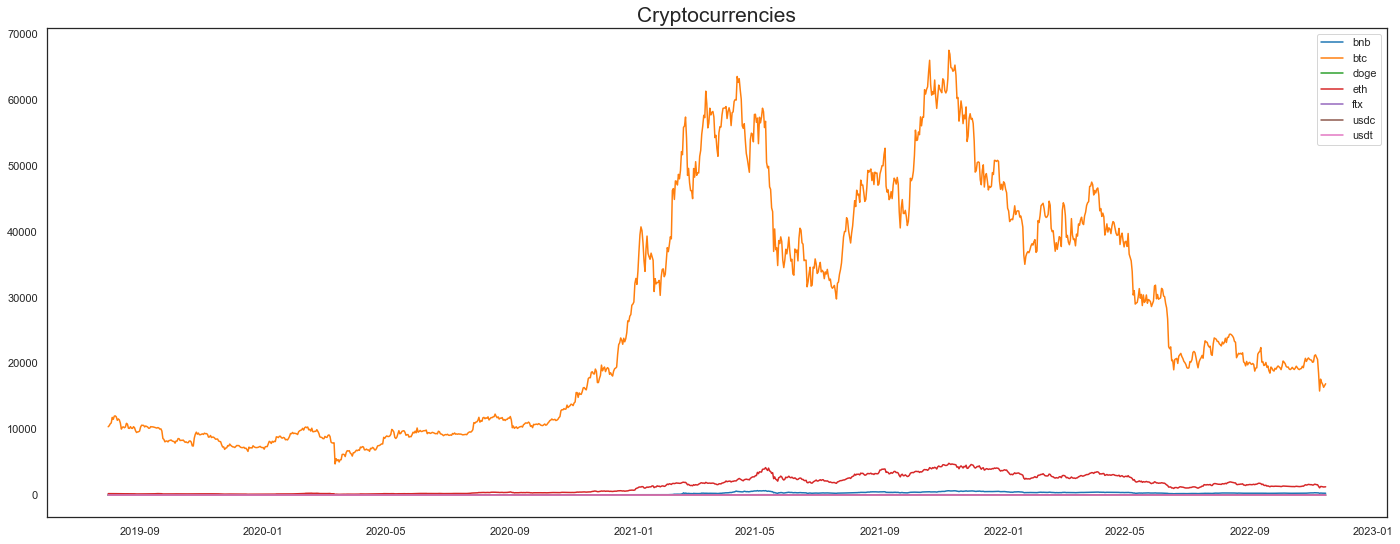

In [10]:
plt.figure(figsize=(24, 9))
for i in range(0, 7):
    plt.plot(coins.index, coins.iloc[:, i], label=coins.columns[i])

plt.title("Cryptocurrencies", fontsize=21)
plt.legend()
plt.show()

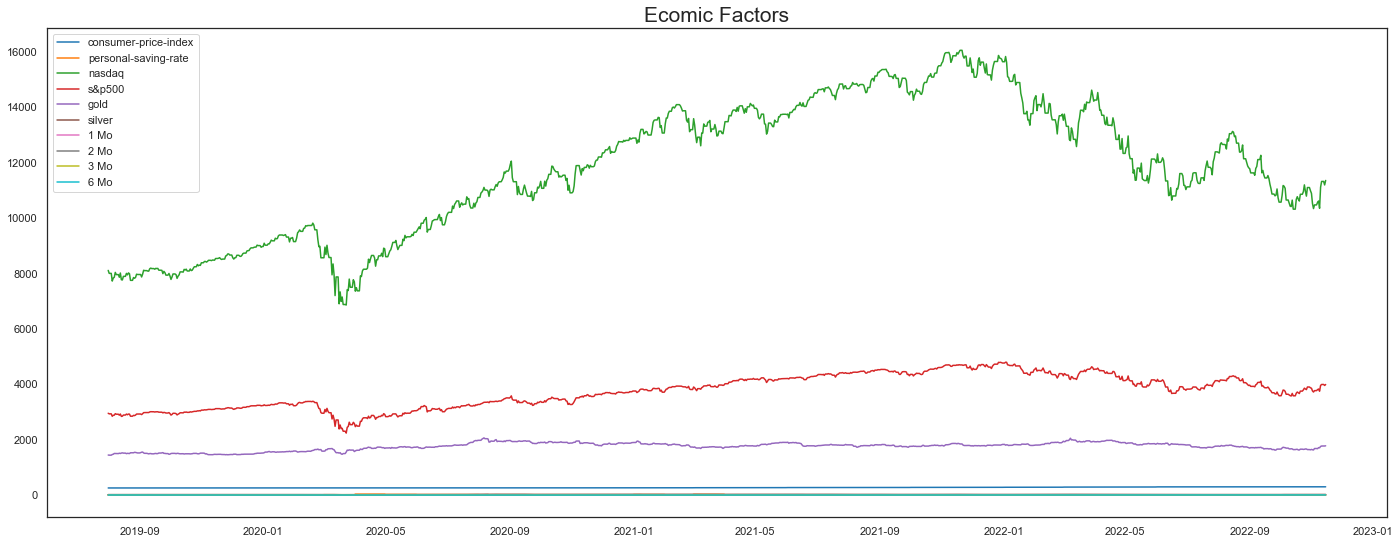

In [11]:
plt.figure(figsize=(24, 9))
for i in range(0, 10):
    plt.plot(factors.index, factors.iloc[:, i], label=factors.columns[i])

plt.title("Ecomic Factors", fontsize=21)
plt.legend()
plt.show()

## *Creación del Index*

In [12]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [13]:
result = []
print(len(coins.columns))

for i in range(len(coins.columns)):
    coin = coins[coins.columns[i]] /  len(coins.columns)
    result.append(coin)
    

ew_index = pd.DataFrame(1 + pd.DataFrame(pd.concat(result, axis=1)).sum(axis=1))
ew_index.set_axis([*ew_index.columns[:-1], "Index"], axis=1, inplace=True)

ew_index.tail(3)

8


,Index
Date,
2022-11-13,2233.135291
2022-11-14,2270.497737
2022-11-15,2304.661041


## *Aqui graficamos*

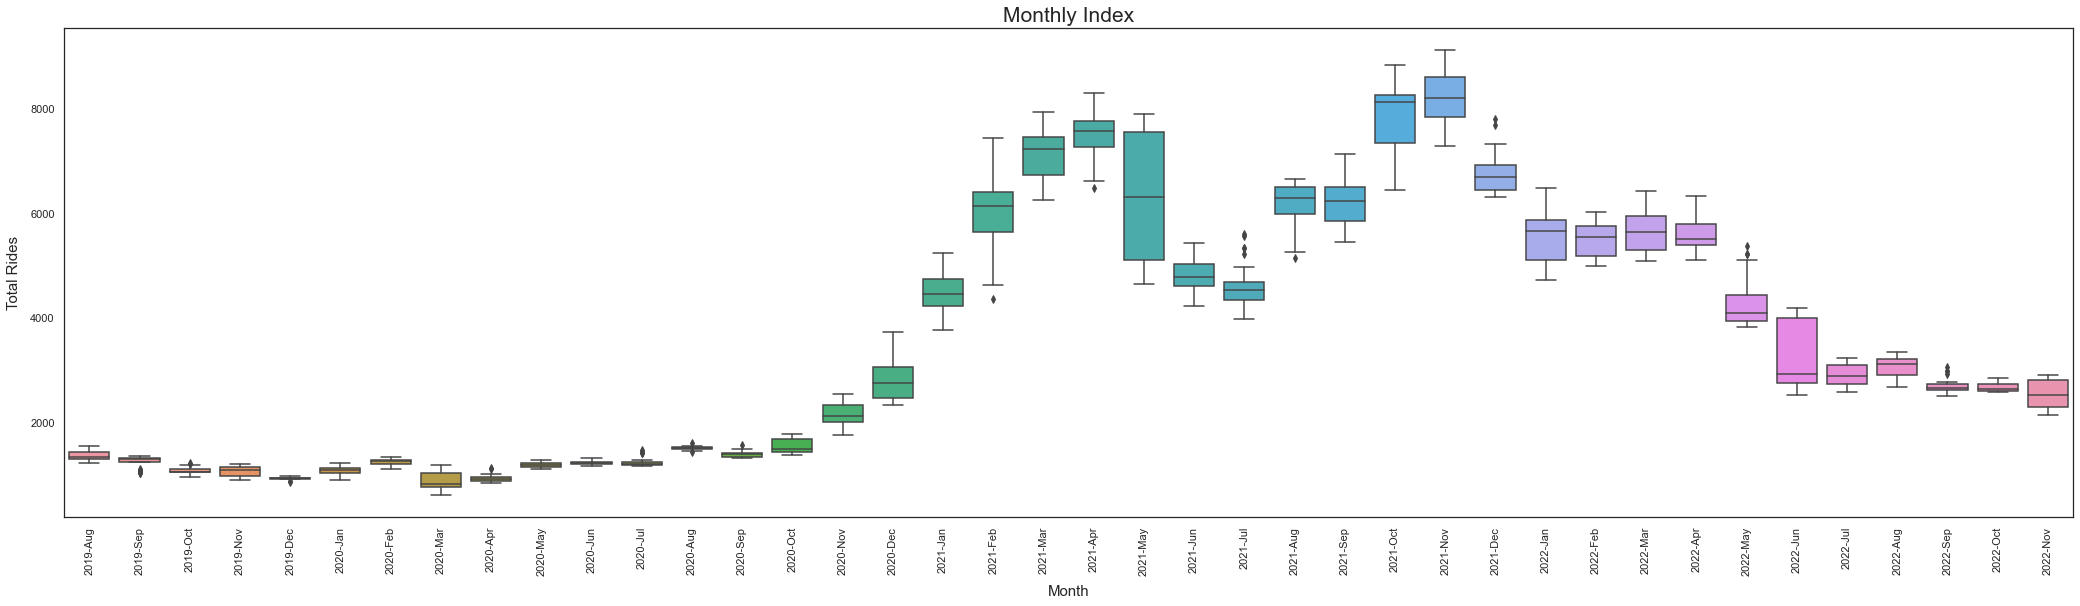

In [14]:
ts_fig, ts_ax = plt.subplots(figsize=(36, 9))
sns.boxplot(x=ew_index.index.strftime("%Y-%b"), y=ew_index.Index, ax=ts_ax)
ts_ax.set_xlabel("Month", labelpad=9, fontsize=15)
ts_ax.set_ylabel("Total Rides", labelpad=9, fontsize=15)
ts_ax.set_xticklabels(ts_ax.get_xticklabels(), rotation=90)
ts_ax.set_title("Monthly Index", fontsize=21)
plt.show()

In [17]:
data = factors.merge(ew_index, how="left", left_on="Date", right_on="Date")
data_nor = prepare_data(data)
data_nor.tail(3)

,consumer-price-index,personal-saving-rate,nasdaq,s&p500,gold,silver,1 Mo,2 Mo,3 Mo,6 Mo,1 Yr,Index
Date,,,,,,,,,,,,
2022-11-13,1.0,0.003247,0.485242,0.685979,0.529585,0.564939,0.981481,0.975610,0.986175,0.978261,0.955882,0.190801
2022-11-14,1.0,0.003247,0.471421,0.672037,0.531367,0.581829,0.984127,0.987805,1.000000,0.984783,0.964286,0.195183
2022-11-15,1.0,0.003247,0.489056,0.685510,0.541718,0.556785,0.997354,1.000000,0.993088,0.982609,0.957983,0.199191


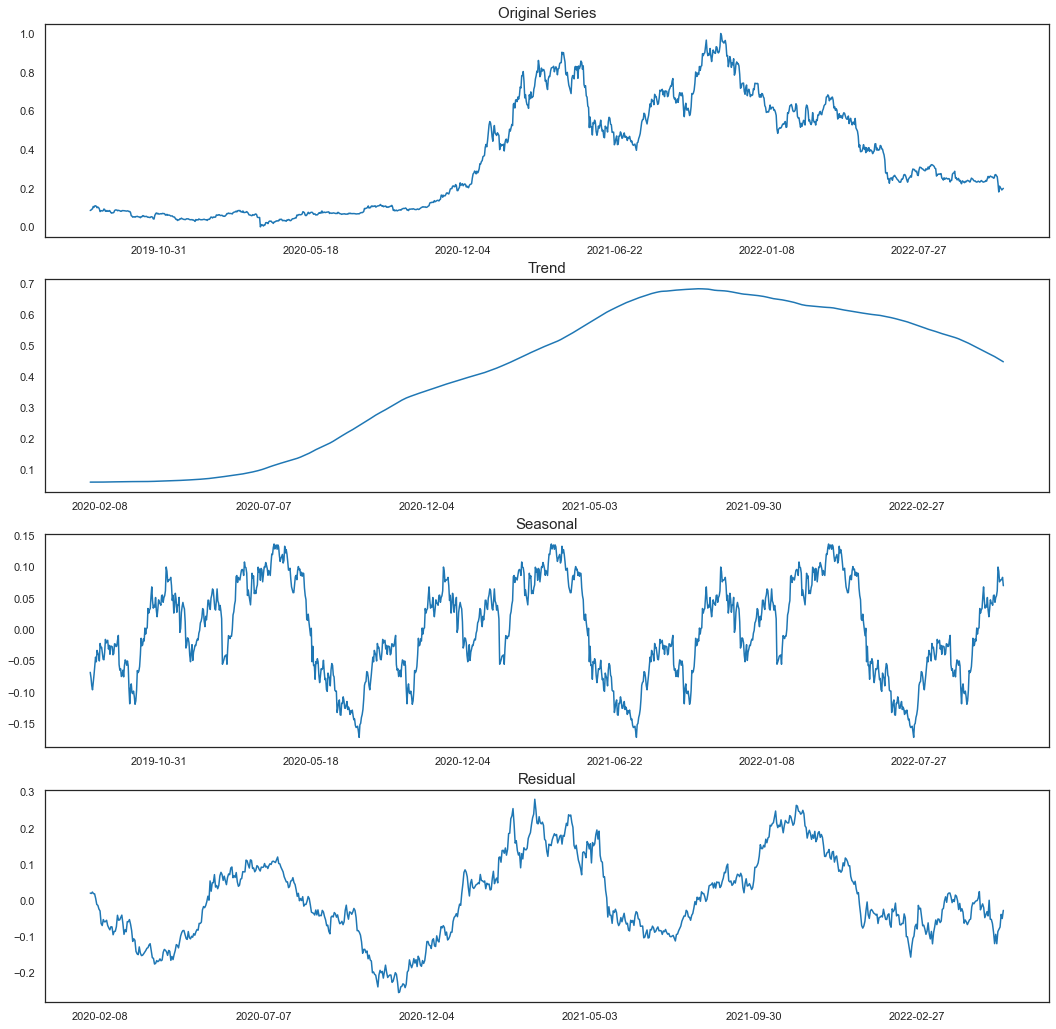

In [18]:
decompose(data_nor.Index, 365)

Separamos los dataset de entrenamiento y test

In [19]:
X_train, X_test, y_train, y_test = time_series_split(data_nor, 0.9505)

## *Implementamos el modelo ARIMA*

Pirmrero se obtienen los parametros ausar en el modelo usando AUTO_ARIMA

In [21]:
arima_param = auto_arima(y_train, start_p=1, d=1, start_q=1, max_p=5, max_q=5, trace=True, seasonal=False)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-5753.803, Time=1.08 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-5756.672, Time=0.50 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-5755.802, Time=0.60 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-5755.797, Time=0.78 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-5758.612, Time=0.16 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 3.123 seconds


In [23]:
algorithm = ARIMA(y_train, order=arima_param.get_params()["order"])
model = algorithm.fit()

In [24]:
# forecast the data
forecast = model.get_forecast(steps=len(y_test))
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the ARIMA forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the ARIMA forecasting are: 
MSE = 0.019946 
RMSE = 0.000398


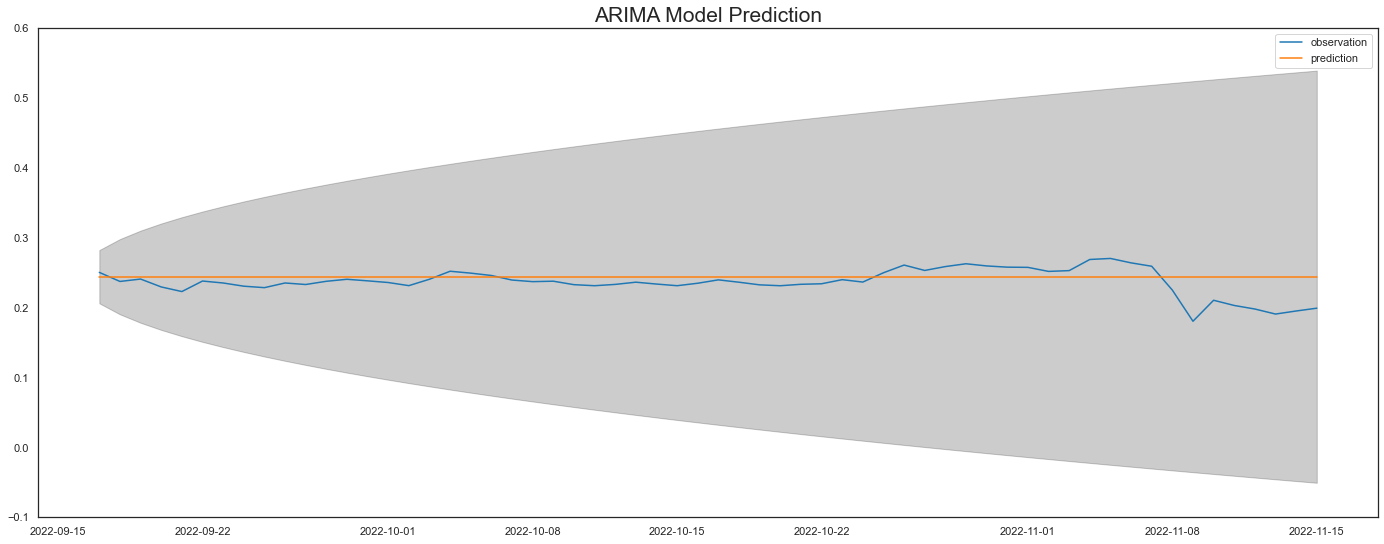

In [25]:
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(prediction.index, prediction, label="prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([-0.1, 0.6])
plt.title("ARIMA Model Prediction", fontsize=21)
plt.legend()
plt.show()

## *Ahora implementamos SARIMAX*

Al igual que le caso anterior se determinan los parametros usando auto_arima

In [26]:
sarimax_param = auto_arima(y_train, exogenous=X_train, m=7, start_p=0, d=1, start_q=0, start_P=0, D=1, start_Q=0, max_p=3, max_q=1, max_P=3, max_Q=1, trace=True, seasonal=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=-4875.606, Time=0.35 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=-5232.037, Time=0.72 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=3.13 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=-4874.647, Time=0.35 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=-5366.196, Time=1.21 sec
 ARIMA(1,1,0)(3,1,0)[7]             : AIC=-5467.987, Time=3.30 sec
 ARIMA(1,1,0)(3,1,1)[7]             : AIC=inf, Time=11.65 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=5.84 sec
 ARIMA(0,1,0)(3,1,0)[7]             : AIC=-5467.389, Time=1.09 sec
 ARIMA(2,1,0)(3,1,0)[7]             : AIC=-5466.162, Time=3.15 sec
 ARIMA(1,1,1)(3,1,0)[7]             : AIC=-5464.098, Time=6.60 sec
 ARIMA(0,1,1)(3,1,0)[7]             : AIC=-5467.918, Time=2.89 sec
 ARIMA(2,1,1)(3,1,0)[7]             : AIC=-5464.311, Time=7.60 sec
 ARIMA(1,1,0)(3,1,0)[7] intercept   : AIC=-5465.983, Time=6.75 sec

Best model:  ARIMA(1,1,0)(3,1,0)[7]

In [28]:
algorithm = SARIMAX(endog=y_train, exog=X_train, order=sarimax_param.get_params()["order"], seasonal_order=sarimax_param.get_params()["seasonal_order"])
model = algorithm.fit(disp=False)

In [29]:
# forecast the data
forecast = model.get_prediction(start=len(y_train), end=len(y_train)+len(y_test)-1, exog=X_test, dynamic=True)
prediction = forecast.predicted_mean
ci = forecast.conf_int()

# check error rate
mse = mean_squared_error(y_test, prediction, squared=False)
rmse = mean_squared_error(y_test, prediction, squared=True)
print("The error rates of the SARIMAX forecasting are: \nMSE = %f \nRMSE = %f" %(mse, rmse))

The error rates of the SARIMAX forecasting are: 
MSE = 0.025615 
RMSE = 0.000656


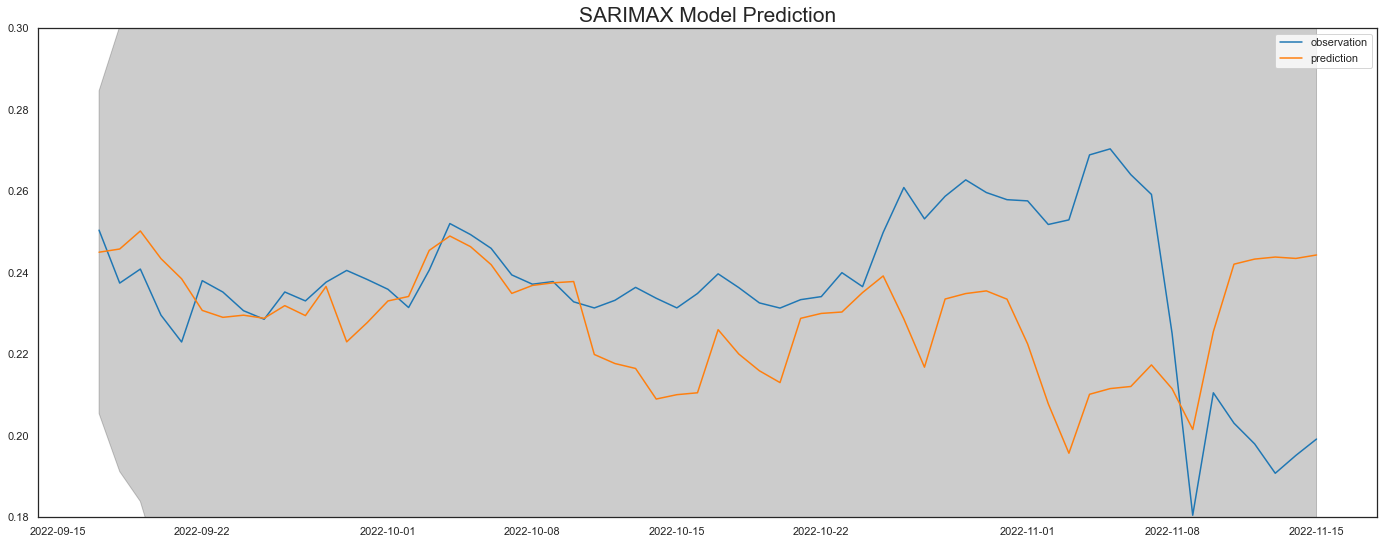

In [30]:
plt.figure(figsize=(24, 9))
plt.plot(y_test.index, y_test, label="observation")
plt.plot(prediction.index, prediction, label="prediction")
plt.fill_between(ci.index, ci.iloc[:, 0], ci.iloc[:, 1], color="k", alpha=0.2)
plt.ylim([0.18, 0.3])
plt.title("SARIMAX Model Prediction", fontsize=21)
plt.legend()
plt.show()